In [1]:
import sys
sys.path.append("/tf/easl-eye")

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

## Local Package
import easl_eye as eye
from easl_eye.io import *
from easl_eye.preprocess import eyes as blink
from easl_eye.viz import raw_gaze_plot

In [4]:
# Loading the two different datasets
image_tracking = get_viewer_tracking_info(url="http://amc-tensor1.ucdenver.pvt/eyetracking")
eye_tracking = load_eyetracking_data(fname="/tf/eye-tracking/test_gaze_data.csv")

In [5]:
eye_tracking = blink.format_data(eye_tracking, 
                                 screen_size=(59.789,33.631), # cm
                                 screen_res=(2560,1440), # px
                                 viewing_dist=82) # cm

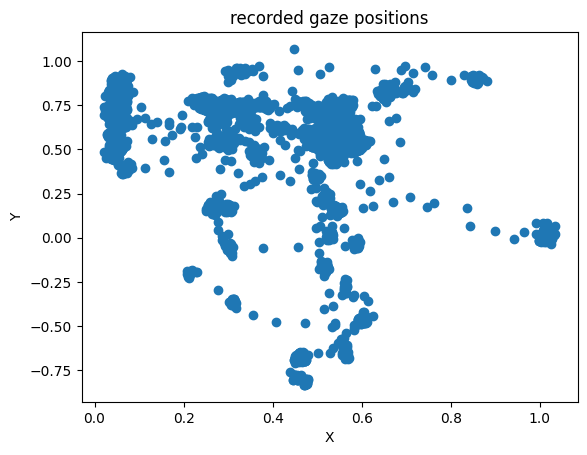

In [6]:
raw_gaze_plot(eye_tracking)

In [7]:
right_gaze = blink.classify(eye_tracking, 'right', roi_x=[0.2, 0.9])
left_gaze = blink.classify(eye_tracking, 'left')

/usr/local/lib/python3.8/dist-packages/cateyes/utils.py:365: UserWarning: 

Irregular sampling rate detected. This can lead to impaired performance with this classifier. Consider resampling your data to a fixed sampling rate. Setting sampling rate to average sample difference.
  warnings.warn(WARN_SFREQ)
/usr/local/lib/python3.8/dist-packages/cateyes/utils.py:365: UserWarning: 

Irregular sampling rate detected. This can lead to impaired performance with this classifier. Consider resampling your data to a fixed sampling rate. Setting sampling rate to average sample difference.
  warnings.warn(WARN_SFREQ)


In [8]:
right_gaze

,timestamp_hardware,timestamp_in_seconds,segment_id,segment_class,right_x,right_y,in_roi_filter_x
0,415541834440,1.662167e+09,0,Fixation,0.26330816745758057,0.7664732933044434,True
1,415541842774,1.662167e+09,0,Fixation,0.24701371788978577,0.7690545916557312,True
2,415541851107,1.662167e+09,0,Fixation,0.2643909752368927,0.7783610224723816,True
3,415541859440,1.662167e+09,0,Fixation,0.2460821270942688,0.782042920589447,True
4,415541867773,1.662167e+09,0,Fixation,0.2599569857120514,0.791050374507904,True
...,...,...,...,...,...,...,...
9031,415617095119,1.662468e+09,614,Fixation,0.24369382858276367,0.7459956407546997,True
9032,415617103452,1.662468e+09,614,Fixation,0.25561171770095825,0.769724428653717,True
9033,415617111794,1.662468e+09,614,Fixation,0.2565777599811554,0.7650485038757324,True
9034,415617120127,1.662468e+09,614,Fixation,0.2528960406780243,0.751578152179718,True


In [13]:
right_gaze.in_roi_filter_x.unique()

array([ True, False])

In [29]:
from cateyes import plot_segmentation, continuous_to_discrete, discrete_to_continuous
import numpy as np

In [25]:
# Create a lambda function to check if a pandas series switches to a true or false value
# label_switch = lambda series: series.diff().map({1: 'into_roi', -1: 'out_of_roi'})
label_switch = lambda series: series.diff()

label_switch(right_gaze['in_roi_filter_x'])

0         NaN
1       False
2       False
3       False
4       False
        ...  
9031    False
9032    False
9033    False
9034    False
9035    False
Name: in_roi_filter_x, Length: 9036, dtype: object

In [38]:
df = pd.DataFrame({
    'timestamp': right_gaze['timestamp_in_seconds'].values,
    'roi': right_gaze['in_roi_filter_x'].values
})
df['label'] = label_switch(df['roi'])

def compare_cols(df, col1, col2):
    # Define a function to apply to each row
    def label_row(row):
        if row[col2]:
            if row[col1]:
                return 'into_roi'
            else:
                return 'out_of_roi'
        else:
            return np.nan

    # Apply the function to each row
    df['result'] = df.apply(label_row, axis=1)
    return df

df = compare_cols(df, 'roi', 'label')

df = df.dropna(subset=['result'])

ev_idx, ev_names = discrete_to_continuous(right_gaze["timestamp_in_seconds"], df["timestamp"], df["result"])
right_gaze["Event_Idx"] = ev_idx
right_gaze["Event_Name"] = ev_names

right_events = continuous_to_discrete(right_gaze["timestamp_in_seconds"], right_gaze["Event_Idx"],
                                      right_gaze["Event_Name"])

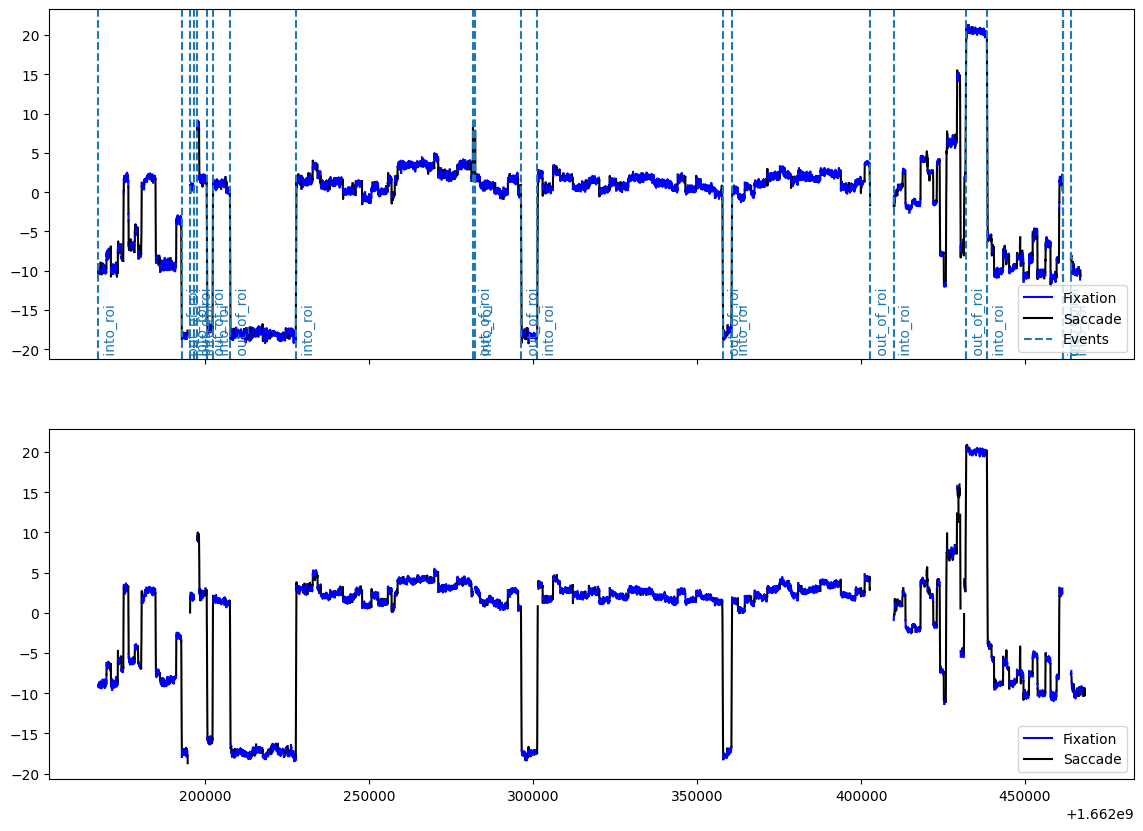

In [41]:
# convert continuous ids and descriptions to discrete timepoints and descriptions
(seg_time, seg_class) = continuous_to_discrete(right_gaze['timestamp_in_seconds'], right_gaze['segment_id'], right_gaze['segment_class'])


# ev_idx, ev_names = discrete_to_continuous(right_gaze["timestamp_in_seconds"], right_gaze["timestamp_in_seconds"], right_gaze["in_roi_filter_x"])
# right_gaze["Event_Idx"] = ev_idx
# right_gaze["Event_Name"] = ev_names

# right_events = continuous_to_discrete(right_gaze["timestamp_in_seconds"], right_gaze["Event_Idx"],
#                                       right_gaze["Event_Name"])

# plot the classification results
fig, axes = plt.subplots(2, figsize=(14, 10), sharex=True)
plot_segmentation(
    eye_tracking['right_x_deg'], 
    times=right_gaze['timestamp_in_seconds'],
    segments=(seg_time, seg_class),
    events=right_events, 
    ax=axes[0])

# convert continuous ids and descriptions to discrete timepoints and descriptions
(seg_time, seg_class) = continuous_to_discrete(left_gaze['timestamp_in_seconds'], left_gaze['segment_id'], left_gaze['segment_class'])
plot_segmentation(
    eye_tracking['left_x_deg'], 
    times=left_gaze['timestamp_in_seconds'],
    segments=(seg_time, seg_class),
    events=None, ax=axes[1])
# plot_segmentation(y_deg, times, segments=(seg_time, seg_class), events=None, ax=axes[1],
#                   show_legend=False);

plt.show()